In [81]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
import arviz as az

hamiltorch.set_random_seed(123)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [82]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [83]:
# mixture of gaussians

m = torch.distributions.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([0.4, 0.6])),
    torch.distributions.Normal(torch.tensor([-2., 3.]), torch.tensor([0.4, 1.])))


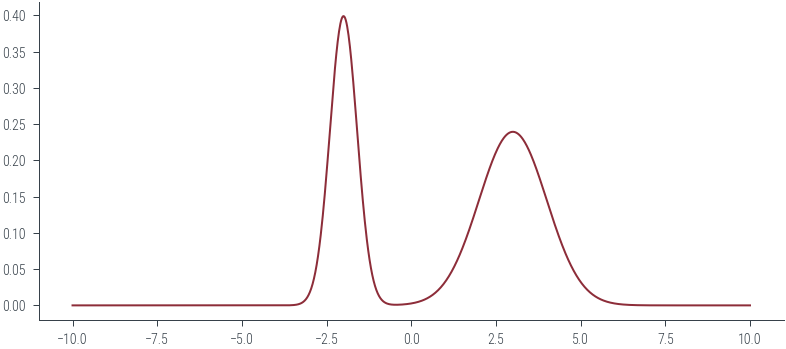

In [84]:
# plot the distribution

x = torch.linspace(-10, 10, 1000)
plt.plot(x, torch.exp(m.log_prob(x)))

In [85]:
def get_samples(m, x0, seed=42):
    torch.manual_seed(seed)
    samples = [x0.item()]
    for i in range(1000):
        xi = torch.distributions.Normal(torch.tensor(samples[-1]), 5).sample()
        # Check if log-density is higher at new sample
        if m.log_prob(xi) > m.log_prob(torch.tensor(samples[-1])):
            samples.append(xi.item())  
        else:
            samples.append(samples[-1])
    return samples
x0 = torch.tensor([0.1])  # Initial value



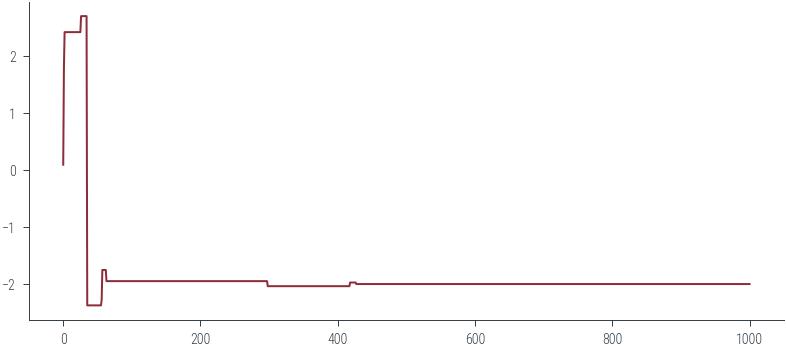

In [86]:
samples = get_samples(m, x0, 42)
plt.plot(samples)

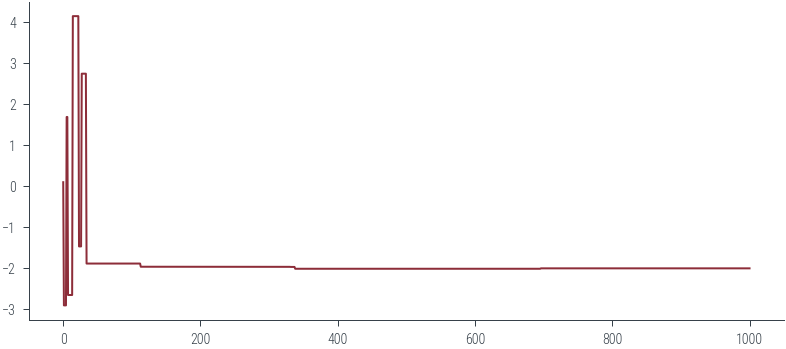

In [87]:
samples = get_samples(m, x0, 10)
plt.plot(samples)

In [88]:
def get_samples_jump(m, x0, seed=42):
    torch.manual_seed(seed)
    samples = [x0.item()]
    for i in range(10000):
        xi = torch.distributions.Normal(torch.tensor(samples[-1]), 1).sample()
        # Find acceptance probability
        a = m.log_prob(xi) - m.log_prob(torch.tensor(samples[-1]))
        a = torch.exp(a)
        # Check if log-density is higher at new sample
        if a > 1:
            samples.append(xi.item())
        else:
            u = torch.rand(1)
            if u < a:
                samples.append(xi.item())
            else:
                samples.append(samples[-1])
    return samples
    

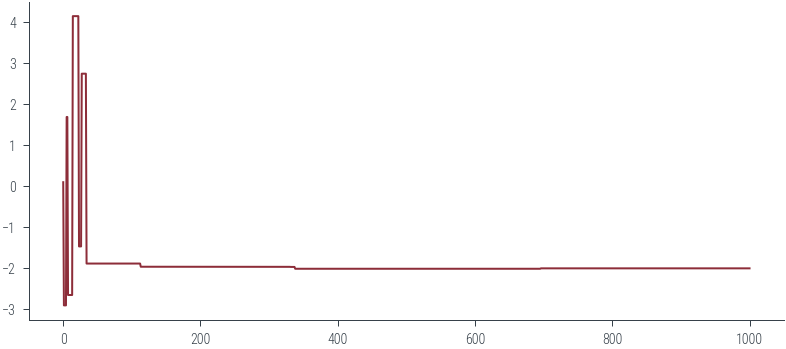

In [89]:
get_samples_jump(m, x0, 42)
plt.plot(samples)

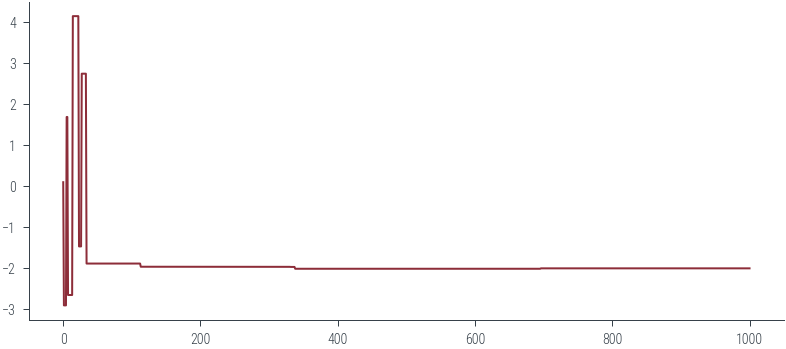

In [90]:
get_samples_jump(m, x0, 2)
plt.plot(samples)

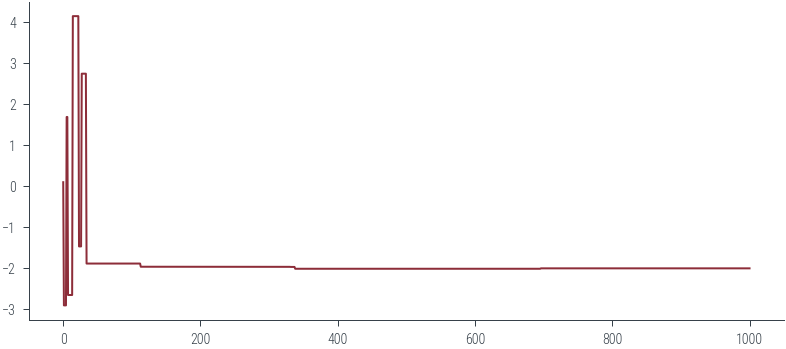

In [91]:
get_samples_jump(m, x0, 10)
plt.plot(samples)

<AxesSubplot:>

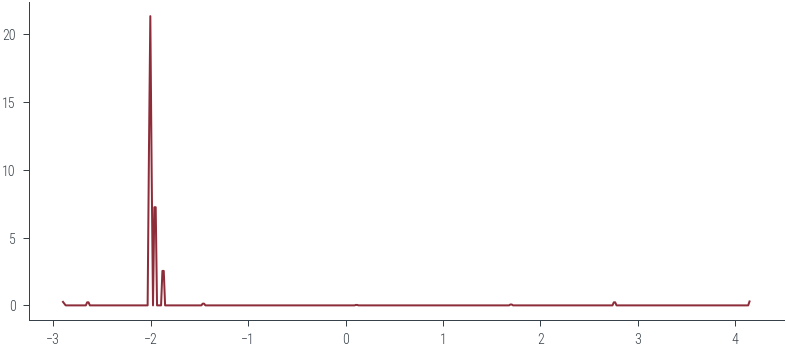

In [92]:
az.plot_kde(np.array(samples))

In [96]:
# use Hamiltorch 
import hamiltorch

def log_prob(x):
    return m.log_prob(x)


N = 10000
step_size = .3
L = 5

hamiltorch.set_random_seed(123)
params_init = torch.zeros(1)
params_hmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
0d:00:00:19 | 0d:00:00:00 | #################### | 10000/10000 | 501.14       
Acceptance Rate 0.98


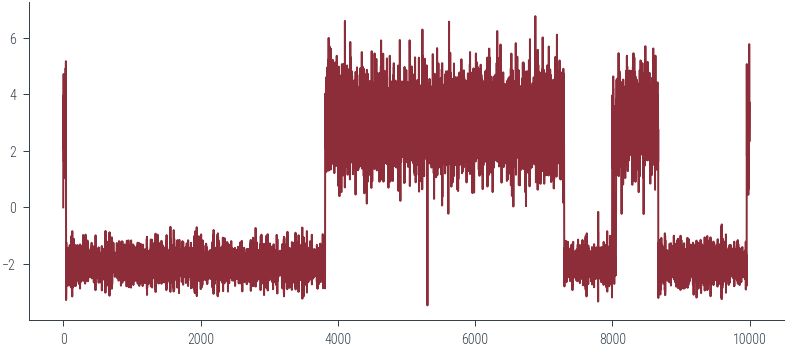

In [97]:
plt.plot(torch.stack(params_hmc).numpy())

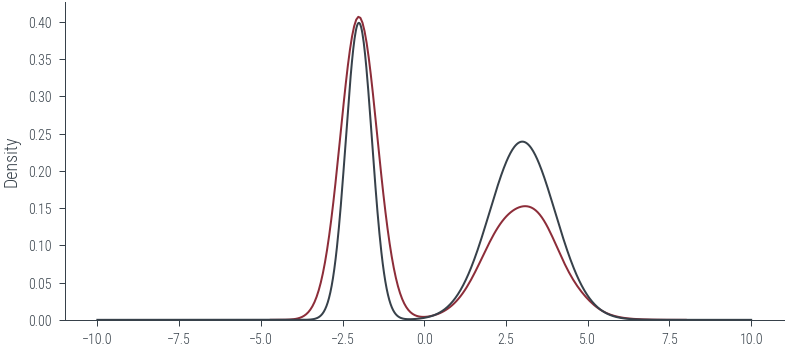

In [98]:
sns.kdeplot(torch.stack(params_hmc).numpy().flatten())
plt.plot(x, torch.exp(m.log_prob(x)))

In [101]:
import torch
import torch.distributions as dist

def random_walk_metropolis_hastings(target_dist, num_samples, initial_sample, proposal_std):
    samples = [initial_sample]
    current_sample = initial_sample

    for _ in range(num_samples):
        # Propose a new sample from a normal distribution (random walk)
        proposal = torch.normal(current_sample, proposal_std)

        # Calculate the acceptance ratio
        log_acceptance_ratio = target_dist.log_prob(proposal) - target_dist.log_prob(current_sample)

        # Accept or reject the proposal
        if torch.log(torch.rand(1)) < log_acceptance_ratio:
            current_sample = proposal

        samples.append(current_sample)

    return torch.stack(samples[1:])

# Example usage:
# Define your target distribution (e.g., a normal distribution)

#target_distribution = dist.Normal(3.0, 1.0)
target_distribution = m

# Number of samples to generate
num_samples = 1000

# Initial sample
initial_sample = torch.tensor(0.0)

# Standard deviation of the proposal distribution (controls the step size)
proposal_std = 0.5

# Generate samples using RWMH
samples = random_walk_metropolis_hastings(target_distribution, num_samples, initial_sample, proposal_std)

# Now 'samples' contains samples from the target distribution


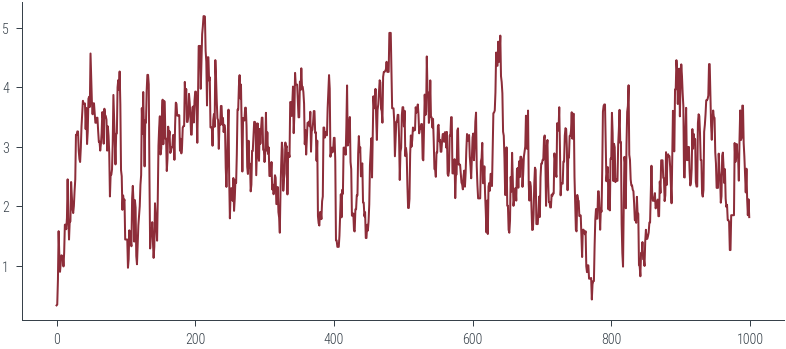

In [102]:
plt.plot(samples)